In [26]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, Embedding, InputLayer
from keras.layers import LSTM, Lambda, concatenate, Bidirectional, Concatenate, SpatialDropout1D

from keras.utils.vis_utils import plot_model
import keras
from keras.layers.merge import add
import pydot
import numpy as np
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
import sys
import io

# Loading Training Data

In [27]:
print("Loading text data...")
text = io.open('data/atahualpa-yupanqui-lyrics.txt', encoding='utf-8').read().lower()
print('corpus length:', len(text))


Loading text data...
corpus length: 45186


In [28]:
Tx = 30
chars = sorted(list(set(text)))
num_classes = len(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print('number of unique characters in the corpus:', len(chars))


number of unique characters in the corpus: 44


In [29]:
def build_data(text, Tx = 30, stride = 3):
    """
    Create a training set by scanning a window of size Tx over the text corpus, with stride 3.
    
    Arguments:
    text -- string, corpus of Shakespearian poem
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels
    """
    
    X = []
    Y = []

    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])

    
    print('number of training examples:', len(X))
    
    return X, Y

In [30]:
def vectorization(X, Y, n_x, char_indices, Tx = 30):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- List of training examples
    Y -- List of training labels
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))
    """
    
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=np.bool)
    y = np.zeros((m, n_x), dtype=np.bool)
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1
        
    return x, y 

# Create Training Set and Vectorize Data

In [31]:
print("Creating training set...")
X, Y = build_data(text, Tx=Tx, stride = 3)
print("Vectorizing training set...")
x, y = vectorization(X, Y, n_x = len(chars), char_indices = char_indices, Tx=Tx) 
print("Loading model...")

Creating training set...
number of training examples: 15052
Vectorizing training set...
Loading model...


# Building the Model

In [32]:
model_config = {
    'rnn_width': 64,
    'rnn_depth': 3,
    'rnn_dropout': 0.3,
    'bidirectional': True
}

In [92]:
continue_learning = True
model_path = "models/atahualpa_model_res.h5"

In [93]:
def new_lstm_cell(rnn_width, rnn_dropout, bidirectional=True, return_sequences=False):
    if bidirectional:
        return Bidirectional(LSTM(rnn_width, recurrent_dropout=rnn_dropout, dropout=rnn_dropout,return_sequences=return_sequences))
    else:
        return LSTM(rnn_width, recurrent_dropout=rnn_dropout, dropout=rnn_dropout,return_sequences=return_sequences)

In [94]:
def make_lstm_layers(input, rnn_width, rnn_depth, rnn_dropout, bidirectional=True):
    layer_list = []
    layer = input
    for i in range(rnn_depth):
        return_sequences = i < rnn_depth - 1
        prev_layer = input if i == 0 else layer_list[-1]
        layer = new_lstm_cell(rnn_width, rnn_dropout, bidirectional=bidirectional, return_sequences=return_sequences)
        
        layer_list.append(layer)
    return layer, layer_list
    

In [95]:
def make_residual_lstm_layers(input, rnn_width, rnn_depth, rnn_dropout, bidirectional=True):
    """
    The intermediate LSTM layers return sequences, while the last returns a single element.
    The input is also a sequence. In order to match the shape of input and output of the LSTM
    to sum them we can do it only for all layers but the last.
    """
    x = input
    layer_list = []
    for i in range(rnn_depth):
        return_sequences = i < rnn_depth - 1
        x_rnn = Bidirectional(LSTM(rnn_width, recurrent_dropout=rnn_dropout, dropout=rnn_dropout, return_sequences=return_sequences))(x)
        if return_sequences:
            # Intermediate layers return sequences, input is also a sequence.
            if i > 0 or input.shape[-1] == rnn_width:
                x = add([x, x_rnn])
            else:
                # Note that the input size and RNN output has to match, due to the sum operation.
                # If we want different rnn_width, we'd have to perform the sum from layer 2 on.
                x = x_rnn
        else:
            # Last layer does not return sequences, just the last element
            # so we select only the last element of the previous output.
            def slice_last(x):
                return x[..., -1, :]
            x = add([Lambda(slice_last)(x), x_rnn])
        layer_list.append(x_rnn)
    return x, layer_list

In [96]:
def create_model_residual():
    inputs = keras.Input(shape=(Tx,len(chars)))
    lstm_layer, layer_list = make_residual_lstm_layers(inputs, **model_config)
    dense_layer = keras.layers.Dense(len(chars), activation='softmax')(lstm_layer)
    model = keras.Model(inputs=inputs, outputs=dense_layer)
    optimizer = keras.optimizers.Adam(learning_rate=4e-3)
    model.compile( loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [97]:
# Simple Deep LSTM Model without Residual Units
def create_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(Tx, len(chars))))
    model.add(LSTM(128, input_shape=(Tx, len(chars)), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(len(chars), activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=4e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [98]:
model = None
if continue_learning:
    model = load_model(model_path)
else:
    model = create_model_residual()

In [99]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 44)       0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 30, 100)      38000       input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 30, 100)      60400       bidirectional_5[0][0]            
__________________________________________________________________________________________________
add_4 (Add)                     (None, 30, 100)      0           bidirectional_5[0][0]            
                                                                 bidirectional_6[0][0]      

In [100]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p = probas.ravel())
    return out

In [101]:
history = model.fit(x, y, batch_size=128, epochs=1, verbose=True)

Epoch 1/1
15052/15052 [==============================] - 34s 2ms/step - loss: 1.2075


In [76]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):

    loss = history.history['loss']
    x = range(1, len(loss) + 1)


    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

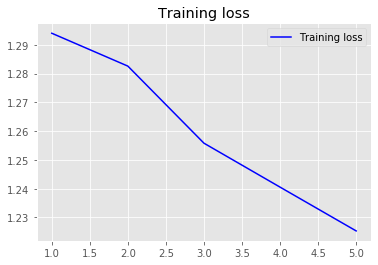

In [77]:
plot_history(history)

In [78]:
# serialize weights to HDF5
model.save("models/atahualpa_model_res.h5", overwrite=True)
print("Saved model to disk")

Saved model to disk


In [106]:
def generate_output(temperature=1.0):
    generated = ''
    usr_input = input("Start typing the beginning of your lyrics. Lyric-genius will complete it.\n Your input is: ")
    # zero pad the sentence to Tx characters.
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(300):

        x_pred = np.zeros((1, Tx, len(chars)))
        
        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        print(preds)
        next_index = sample(preds, temperature = temperature)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [107]:
generate_output(temperature=0.3)

Start typing the beginning of your lyrics. Lyric-genius will complete it.
 Your input is: hello 


Here is your poem: 

hello [8.46317559e-02 9.74403636e-04 1.30486340e-04 5.77570579e-04
 2.66821386e-04 3.03336157e-04 3.96297284e-04 2.02645733e-05
 1.79087838e-05 1.35476608e-03 1.23761885e-01 4.45589935e-03
 2.39810590e-02 8.09821337e-02 1.87180370e-01 3.41648841e-03
 1.16461003e-02 4.18210076e-03 6.64300576e-04 5.93079021e-03
 7.44858789e-06 2.79955585e-02 2.18029153e-02 1.46310031e-02
 1.83619838e-03 4.86299805e-02 4.41715792e-02 2.44625262e-04
 2.05601230e-02 9.16162133e-02 4.95208288e-03 1.89796817e-02
 1.33242056e-01 1.88451540e-02 3.67207476e-03 1.37032521e-05
 1.14091123e-02 7.82003975e-04 1.00786937e-03 7.26728613e-05
 2.36982178e-05 4.88706981e-04 1.27069172e-04 1.37514144e-05]
e[2.8738334e-06 1.0567713e-03 5.6623056e-10 1.4903756e-07 4.0034516e-07
 3.3325100e-06 3.7838723e-09 9.0958117e-08 1.5491439e-09 4.7303144e-09
 7.7354671e-05 2.1632745e-07 1.9800190e-04 1.3546809e-06 2.

o[5.45211792e-01 4.34314534e-02 6.87560474e-04 5.40805107e-04
 5.01376484e-03 7.36652059e-04 9.18123442e-06 1.54295975e-07
 2.37987024e-06 4.89293325e-06 1.17885174e-04 7.14980811e-03
 6.65590633e-04 1.40007469e-03 9.11178868e-05 2.13304273e-04
 1.43707657e-05 7.54980101e-06 1.78285874e-04 7.64031429e-05
 3.16955806e-07 5.52040851e-03 7.09823519e-03 5.65454289e-02
 7.98295194e-04 3.93583497e-04 3.93098981e-06 3.13578993e-01
 9.69602820e-03 1.00987767e-04 6.25674002e-05 1.03337668e-04
 2.66891875e-04 1.16728428e-04 1.93938304e-05 3.83959730e-07
 5.73068428e-06 6.66421374e-06 3.92261654e-06 1.02460660e-06
 6.48473288e-05 1.14396812e-06 5.76480888e-05 5.31154001e-07]

[1.0738606e-01 8.6255022e-04 2.3270295e-05 1.3822530e-03 3.8094414e-04
 4.4882377e-06 3.9627164e-05 7.1855061e-06 2.5969820e-07 1.5364996e-05
 3.2833975e-02 9.0659168e-03 5.3981036e-02 6.7484374e-03 1.7435011e-01
 4.7296751e-04 6.1219023e-03 1.3203289e-03 9.4472244e-04 9.1775146e-04
 1.6087212e-07 2.6459238e-01 4.7177523e-02

t[1.38473766e-07 4.80797235e-06 1.47845625e-09 2.07443459e-12
 3.70647825e-07 4.54583496e-05 1.58681786e-07 1.18652832e-09
 1.14304717e-08 4.19364161e-11 3.58283490e-01 9.31696107e-08
 2.99887211e-06 2.32776474e-05 2.03845440e-03 7.44012425e-08
 1.61439573e-07 3.25272208e-06 5.52395172e-02 2.16671069e-07
 6.64339428e-09 1.69164719e-04 6.48040896e-07 1.21986787e-07
 5.83920658e-01 7.19736875e-07 1.10082766e-07 1.77071401e-04
 1.45179065e-05 5.78594290e-06 2.35718221e-06 6.44290807e-08
 3.97297928e-09 2.79607605e-07 1.07071844e-10 5.29168542e-10
 1.28684383e-10 2.00822469e-05 1.73814606e-05 2.53081871e-05
 7.76521158e-09 2.96621920e-06 3.80601534e-07 2.74923084e-10]
o[5.6007365e-03 8.0071419e-01 4.1397907e-06 7.2480219e-08 8.4853936e-03
 1.6115353e-01 4.2525297e-08 3.9098003e-07 3.7340140e-09 2.8119057e-10
 4.1126528e-05 3.3609558e-06 1.3806490e-05 5.1045230e-05 3.2156728e-05
 1.3776599e-06 2.0672726e-06 8.6599336e-08 6.8909515e-07 3.8745839e-06
 2.4596549e-08 2.0869040e-05 4.5781944e-06

o[5.03065288e-01 1.97524294e-01 1.27880313e-02 1.41459444e-04
 2.20656797e-01 1.35727106e-02 2.03857162e-05 2.53997132e-06
 3.02764704e-07 7.79794860e-08 2.25767053e-05 3.31208867e-05
 5.29552490e-05 8.25658499e-05 5.29218232e-05 7.99720874e-05
 1.68353296e-07 1.22934330e-06 3.97731037e-06 6.03741028e-05
 1.68476816e-07 2.55795283e-04 7.86395540e-05 1.85391342e-03
 2.98814778e-03 1.62008055e-05 4.76693344e-07 3.14516239e-02
 1.44967865e-02 6.17753030e-05 1.38682753e-06 9.71553891e-06
 3.48723901e-04 2.54028535e-04 1.59630326e-06 2.17206875e-07
 7.24891379e-07 1.35443690e-06 1.14042350e-05 5.95416850e-07
 3.10268842e-06 7.33701370e-07 1.10463611e-06 5.53412072e-08]
'[8.45650017e-01 1.04259893e-01 9.72457579e-04 3.29454732e-03
 3.45169938e-05 3.24823111e-02 1.08316141e-04 8.10817219e-05
 3.49832021e-07 8.62531977e-07 6.01724205e-05 1.83160755e-05
 3.97558761e-05 2.47821072e-06 2.67196656e-03 2.85441411e-06
 4.73980162e-06 1.22995925e-06 1.75555341e-03 5.94308221e-06
 1.84130826e-07 2.640

a[4.46651393e-05 1.02242656e-01 7.35240135e-09 1.06806564e-08
 5.10834761e-05 6.14326971e-04 1.00151128e-05 4.24980925e-07
 3.85860039e-06 1.33348962e-07 2.68913014e-03 3.02622240e-04
 8.16164985e-02 2.37208568e-02 5.66615316e-04 3.67292960e-04
 1.28419669e-02 6.92092071e-05 1.28174135e-02 4.71268920e-03
 6.53566417e-07 1.77847832e-01 2.04646245e-01 3.03079605e-01
 3.01877689e-03 2.41724251e-06 1.50058375e-04 3.10067628e-02
 2.54955571e-02 4.98475553e-03 5.25876135e-03 6.76857162e-05
 6.01873442e-04 4.54089663e-04 2.96207247e-07 1.21803552e-07
 1.55403299e-07 5.25920950e-06 1.69575032e-05 4.65363482e-05
 3.29172268e-04 3.13482480e-04 1.37697361e-06 9.92558071e-08]
l[1.2849022e-04 5.7363704e-02 1.6785611e-07 8.4064806e-07 1.9122792e-05
 4.9085938e-04 1.3558376e-04 7.9714931e-07 4.3357268e-06 2.5302000e-07
 2.8779104e-02 4.6712580e-06 2.6192830e-03 2.6993703e-05 1.1699721e-03
 4.0122959e-05 1.1993066e-02 7.9800003e-08 1.3782205e-02 2.2384373e-05
 6.5155346e-06 8.2004297e-01 5.6537758e-03

 [4.0170344e-04 9.7326199e-05 4.3888040e-06 1.7182584e-04 2.4429994e-05
 8.7957960e-06 6.0809612e-06 2.1500857e-05 1.0211537e-05 1.8192024e-05
 2.6437927e-02 2.3538997e-02 7.6456115e-02 2.3065084e-03 2.4793683e-02
 8.6189164e-03 3.4065221e-02 3.6433116e-03 4.1922801e-03 1.7476561e-02
 1.0287462e-06 2.0796868e-03 8.2484454e-02 5.4248579e-02 2.4627144e-03
 3.6996108e-01 2.5496790e-03 2.8606581e-02 1.3875419e-01 6.1241116e-02
 1.7616306e-03 2.7765820e-02 4.0066778e-03 2.7219902e-04 1.2690740e-04
 2.0349003e-06 8.0749724e-04 4.5668735e-04 5.1550287e-05 2.3048318e-05
 1.7960441e-05 8.9999867e-06 4.6204814e-06 1.1215351e-05]
p[7.6748393e-08 8.6806402e-08 8.3301765e-09 2.3242719e-09 2.9161495e-07
 6.4527189e-10 3.7470782e-09 3.2689937e-10 2.6234070e-09 2.3651838e-08
 4.0788984e-01 5.9265938e-07 2.7477739e-05 1.9199601e-06 3.1172401e-01
 4.2475939e-08 9.5599898e-07 3.7706448e-04 5.6638319e-02 4.7122426e-06
 7.8239237e-09 2.1100095e-03 4.6548835e-06 2.1153659e-05 1.7661740e-01
 3.7136666e-05 2.

r[2.9362994e-01 8.3621345e-02 3.3115695e-04 1.1231417e-06 2.3808056e-05
 2.8114775e-03 1.8672021e-02 4.5981409e-04 4.8124083e-04 6.1751394e-05
 1.5004387e-02 1.5291577e-03 1.0102779e-04 2.7435957e-03 1.5834006e-03
 7.5101183e-05 2.1547168e-02 8.4992098e-07 9.4631710e-04 4.6855093e-06
 2.1569629e-05 9.5431153e-03 2.4113627e-02 1.3532324e-04 4.0664277e-03
 3.2741980e-05 2.1434660e-04 8.9666242e-04 5.6849003e-05 2.0625794e-01
 6.0240956e-05 1.3228836e-04 2.8340199e-05 5.0937227e-04 3.8536032e-06
 4.6319819e-06 2.3476427e-06 1.7765176e-02 2.9221642e-01 1.7797237e-04
 2.2809406e-06 1.1820608e-04 3.2183693e-06 7.6215679e-06]

[1.09020375e-01 1.94791879e-03 2.46059335e-06 7.73231750e-06
 1.97217541e-05 8.65897618e-06 1.53846713e-06 1.85646968e-06
 1.55542011e-07 2.95810651e-06 1.46459684e-01 6.81092637e-03
 5.49336933e-02 5.04915230e-02 1.54459774e-02 4.47846105e-04
 5.51417051e-03 1.24996796e-03 1.34000860e-04 4.37216477e-06
 1.61657596e-07 2.34063379e-02 3.36383104e-01 1.17347585e-02
 4.738

e[1.3307919e-04 8.8765246e-01 3.5598262e-07 3.9678074e-08 1.7993302e-06
 1.3531751e-03 7.5976530e-08 1.9156088e-08 1.4648170e-07 1.2546324e-08
 1.9036332e-04 3.2752745e-05 1.3666252e-03 3.3671891e-05 3.9662565e-03
 2.9861385e-05 3.2382479e-04 4.2773822e-06 6.5470638e-04 4.1957109e-04
 1.7145922e-07 9.0211127e-03 8.1200036e-04 3.8932756e-02 7.6775599e-05
 6.8279410e-06 5.8059168e-06 4.7369506e-02 5.6730220e-03 8.1681110e-06
 4.0362343e-06 4.5241439e-05 1.4830488e-04 1.1417297e-04 8.9906509e-09
 2.2563599e-08 4.8107452e-08 3.3722390e-06 1.0901636e-05 2.0414261e-06
 1.5092457e-03 2.2315032e-07 9.3100251e-05 3.2365508e-09]
 [4.1530770e-04 5.0465954e-03 1.7825939e-06 9.3049348e-05 7.2118673e-06
 1.5941421e-05 3.2120505e-07 2.7629306e-07 1.5816963e-06 1.4068032e-06
 2.6328983e-02 1.7158929e-03 2.4488218e-02 1.7033307e-02 3.4329973e-02
 1.3407823e-02 1.8427824e-04 6.3160248e-02 2.0975761e-02 4.3916577e-03
 3.7379738e-07 2.7567381e-01 4.0892377e-02 4.6241488e-03 2.4656097e-03
 2.8424226e-03 1.

s[3.5377976e-01 5.5034393e-01 1.0440609e-05 2.2773698e-05 3.2735319e-05
 7.6822437e-02 2.6360445e-05 1.4679364e-04 6.4668271e-08 1.4244527e-07
 2.3766185e-04 2.5637032e-06 7.8599129e-05 6.7481647e-05 3.0064437e-04
 7.4818754e-04 7.2685798e-05 5.2383177e-07 9.3255807e-03 3.1776608e-07
 5.5283540e-08 1.6658257e-07 3.5888686e-05 7.6773877e-06 2.0840804e-03
 9.2713679e-05 1.9399899e-05 1.0082125e-05 2.6440271e-04 5.0610560e-03
 2.5589365e-04 7.6833721e-06 5.8296969e-06 7.7160446e-05 6.8534712e-07
 1.6542056e-07 1.2899250e-06 7.3724038e-07 1.1728242e-05 4.1578798e-05
 2.9307194e-09 7.6333606e-07 2.3599556e-07 1.0614560e-06]
 [2.97901154e-01 1.11327600e-03 3.29532086e-05 6.57825591e-03
 4.04904858e-05 4.51251035e-05 6.16283724e-05 2.07232893e-06
 5.27438397e-06 2.84564630e-05 8.79698526e-03 2.48759892e-02
 2.98984256e-02 1.83436349e-01 4.85710725e-02 1.67314301e-03
 9.29801818e-03 1.83881610e-03 2.64655944e-04 1.88882230e-04
 1.49840218e-07 1.60317682e-02 6.88468292e-02 1.95337422e-02
 4.494

o[9.56556760e-03 7.18118250e-01 9.02215652e-06 2.83457030e-06
 1.99595839e-01 3.21590342e-02 7.48726279e-07 1.19180368e-04
 2.46823575e-08 4.33422498e-09 6.83557009e-05 1.37971210e-06
 1.84101591e-04 6.73993191e-06 5.71845590e-07 5.14715794e-05
 6.86000021e-07 3.93537903e-07 5.77068977e-06 1.30964245e-05
 1.86632849e-06 6.71398175e-06 9.88403099e-06 2.47671385e-04
 2.30257618e-04 1.02812867e-03 7.11526081e-05 1.46677217e-03
 3.64182368e-02 3.19528015e-04 1.50859421e-07 7.75022636e-06
 3.50623268e-05 2.49109959e-04 9.26755632e-08 7.67203971e-08
 1.07735696e-08 1.23330904e-06 1.75229059e-06 5.30115685e-08
 2.02546602e-07 9.08875997e-09 1.17656236e-06 4.88661511e-09]
 [5.15774451e-03 8.91425926e-03 3.94597237e-06 6.01560714e-05
 6.58191333e-04 8.39520886e-04 1.78531955e-05 2.90839853e-06
 3.88548273e-07 1.14698796e-05 1.21832728e-01 3.86588072e-04
 5.07294759e-02 1.08513899e-01 3.80339101e-02 1.40501987e-02
 2.63705221e-03 2.42918059e-02 1.88913007e-04 3.47372191e-03
 2.36731125e-06 1.400

i[9.1328798e-07 1.1240756e-05 1.6415339e-10 1.1577303e-04 3.5642987e-08
 2.6072080e-09 6.0183294e-07 7.0595293e-11 4.0669694e-09 7.5314290e-08
 1.5591710e-03 4.5522763e-03 2.4034930e-03 3.2277533e-04 3.0826326e-03
 5.4262608e-04 1.6106975e-06 3.0009326e-07 8.1207679e-04 1.7035153e-03
 1.2087036e-08 2.5270548e-02 1.7352148e-06 6.7043930e-01 4.5284331e-02
 6.2452484e-04 4.1397925e-06 5.1364228e-02 1.3510247e-01 5.5837661e-02
 5.9171867e-05 1.4116429e-04 2.0049947e-06 3.5883357e-05 3.6713251e-07
 6.4744148e-09 1.7051510e-05 3.3316090e-07 9.3110913e-07 6.1025844e-07
 5.4493098e-04 1.5955164e-04 9.3290451e-09 2.6476127e-10]
n[5.1357233e-06 2.1208238e-05 5.5098520e-10 5.5816551e-09 1.7730015e-07
 4.8268014e-08 1.0302510e-05 5.3882587e-09 1.0270597e-09 1.2209432e-10
 1.5833601e-03 9.5505843e-09 9.2842494e-04 4.0076528e-05 1.5000397e-04
 1.4988899e-06 2.6664736e-07 1.4102269e-06 3.2292858e-03 1.0952535e-06
 4.7673793e-10 5.8301495e-05 2.7971814e-07 1.0259170e-04 9.9045557e-01
 2.7223058e-07 1.

n[4.9494397e-06 2.3882518e-02 6.2427064e-10 2.4013968e-08 5.4140548e-07
 2.9657310e-04 1.0758769e-06 1.2397403e-09 2.1539813e-07 1.4392251e-08
 1.4683452e-01 1.2155015e-03 6.2543519e-02 6.4864784e-02 3.3768140e-02
 1.0241799e-03 3.4071985e-03 2.6919763e-04 4.0583722e-02 1.8842133e-04
 9.2043928e-07 1.2958451e-03 3.0282293e-03 3.4347468e-04 4.4186467e-01
 4.4870827e-05 2.6597449e-04 4.0227391e-02 2.6707649e-02 1.0218114e-01
 1.9692120e-04 3.0610266e-03 5.0287435e-06 1.4642813e-03 4.7156409e-06
 1.3139427e-07 4.3969152e-08 7.8613093e-06 3.8162740e-05 2.4617347e-04
 4.6597092e-05 8.3662344e-05 1.2654624e-07 2.2052264e-08]
o[1.79390132e-03 1.31085336e-01 4.35165134e-07 5.59945256e-05
 1.00241014e-05 7.94566760e-04 6.56078555e-07 3.40891262e-08
 3.16070619e-08 1.45099310e-08 9.46678774e-05 2.90747448e-05
 7.42844164e-01 1.93089843e-04 3.04213754e-05 1.47319608e-03
 1.01434962e-04 4.04092089e-06 9.22669933e-05 1.96506691e-04
 8.52327332e-07 4.94835149e-05 5.28733246e-04 4.81814006e-03
 1.548

a[1.2702653e-01 7.7962184e-01 9.3226799e-06 1.8997056e-07 3.1524422e-05
 1.1161017e-03 4.4677182e-07 3.8956394e-03 3.3415552e-05 6.7736032e-08
 1.3577240e-04 4.6466496e-03 1.5811702e-02 1.7160473e-03 4.8991697e-05
 1.0966051e-04 1.2231473e-04 6.5245404e-05 3.9814509e-05 4.7194542e-05
 1.3918686e-06 4.2298641e-03 1.6569742e-04 9.8950202e-03 7.0646172e-04
 7.5472026e-06 3.6852690e-03 7.6410882e-03 2.9660646e-02 2.1104442e-04
 1.2913510e-05 4.5966153e-05 1.6838425e-05 8.8258348e-03 2.6889448e-04
 2.6164659e-07 1.5914023e-06 5.8568849e-06 2.1599869e-06 7.7377777e-08
 1.3270695e-04 2.4359265e-06 1.5237665e-06 4.1968809e-07]
 [1.4556094e-01 4.4880508e-04 3.2932483e-05 1.0052206e-05 3.1047126e-05
 1.8018856e-05 2.2009264e-05 7.5923599e-05 8.7947137e-06 5.0028808e-05
 9.2827734e-03 1.2152054e-02 1.3218522e-02 1.9223658e-02 2.8146435e-02
 2.2970824e-02 2.0449015e-03 7.3138508e-04 3.2760372e-04 7.8030844e-04
 5.0852373e-07 1.0229005e-02 2.7460560e-02 2.4891566e-02 2.7084060e-04
 1.2088752e-02 5.

 [5.7616366e-05 8.0996862e-05 2.2241554e-07 1.2330434e-04 4.1273411e-06
 4.9879310e-07 8.3624747e-07 2.8461491e-07 2.8706611e-07 7.7269027e-07
 2.8267477e-02 3.5819213e-03 4.1120602e-03 1.3625239e-02 1.4408025e-02
 1.8260430e-03 2.8416284e-03 5.0306924e-02 1.4678846e-03 1.8737031e-04
 1.3256483e-06 1.1260901e-02 8.3926976e-02 7.5429375e-03 1.0095092e-02
 4.4293892e-02 1.3171670e-01 2.1639648e-03 2.5800535e-02 2.7973396e-03
 1.7137072e-03 5.5738354e-01 1.5096992e-04 1.2248114e-04 3.3342232e-05
 1.3417020e-06 1.7640370e-05 2.9326646e-05 1.3354450e-05 2.7445463e-05
 3.4542265e-06 7.5256526e-06 1.6291127e-06 1.1305387e-06]
v[3.4488903e-07 3.1951765e-07 2.6735616e-08 8.3457496e-10 2.3967391e-06
 4.3035263e-07 1.3851385e-07 4.6306992e-10 1.5685552e-08 1.6944476e-08
 2.2960725e-01 1.0282296e-06 1.6350864e-07 2.6078333e-06 1.2917687e-01
 2.3605352e-08 3.3409466e-07 1.5451580e-04 3.4533048e-01 9.6319854e-07
 9.5490922e-09 4.3750839e-05 6.1551796e-06 6.3252969e-07 2.5348350e-01
 1.0275131e-04 7.

c[2.98154731e-07 6.02183992e-09 8.07905792e-07 2.00173440e-06
 2.99466888e-06 1.85046389e-09 1.00332798e-09 5.90840543e-10
 9.17290910e-10 1.36622788e-07 2.98502445e-01 1.72216517e-06
 3.35771347e-06 5.48442040e-06 5.58852077e-01 3.61678417e-07
 1.11959695e-08 2.16791946e-02 4.41950094e-03 4.09507356e-06
 2.93820044e-08 3.73720104e-04 1.69143859e-05 7.23169933e-06
 3.22190821e-02 1.90000792e-05 8.36200726e-08 1.45669775e-02
 3.97862777e-06 4.29867804e-08 6.37248680e-02 2.22178741e-07
 8.98455355e-09 6.56037358e-08 1.04702629e-08 2.04810704e-07
 4.51667756e-06 3.08890804e-03 5.82823850e-06 2.40068557e-03
 1.53920901e-05 5.30909856e-05 2.04540174e-05 4.26807401e-06]
a[1.06446805e-06 1.52826597e-05 3.31023625e-06 2.77816298e-07
 2.01554394e-05 1.04950068e-05 9.88695525e-09 3.94895716e-09
 6.20436992e-07 1.55195366e-07 7.42638877e-05 3.99069348e-03
 1.92209671e-04 2.67541152e-04 4.08406398e-04 8.94179917e-04
 5.92498225e-04 3.09843919e-04 4.52268636e-03 6.91778318e-04
 1.00584384e-06 5.277

u[4.7465937e-07 6.8329507e-05 9.8370890e-08 8.4773028e-08 3.0698427e-08
 1.9921818e-06 1.3656853e-06 3.3968959e-09 4.6523255e-08 2.0848299e-06
 9.0529507e-01 1.1739623e-04 3.3319124e-05 1.5653039e-05 6.1951000e-02
 1.7533776e-04 1.2524163e-05 2.9599576e-04 9.6531697e-03 9.7286429e-06
 1.1222455e-05 2.3403303e-05 1.3724239e-04 1.1504157e-03 2.3109229e-04
 2.5781189e-04 1.6136095e-05 7.9859709e-03 3.7531022e-04 1.1786790e-05
 5.3413323e-04 4.8012698e-06 8.5413683e-07 3.2719970e-04 4.7050833e-08
 2.8718266e-06 1.4031126e-06 2.4950958e-03 4.1116979e-03 2.3258701e-03
 2.2143463e-03 1.4105710e-04 6.5494032e-06 9.9268966e-09]
a[4.8774959e-06 2.2501356e-03 4.3505799e-10 4.9539981e-08 1.3058302e-06
 3.4635016e-06 6.0493162e-09 3.6403540e-06 5.7295796e-07 6.8674280e-09
 4.7858030e-04 7.2355988e-03 3.9859982e-03 1.6948951e-03 3.3725920e-04
 5.8003981e-05 2.2740152e-03 6.8688998e-04 2.5224618e-03 1.4510022e-04
 4.5321937e-07 7.1511924e-01 4.4014170e-03 2.4928439e-01 6.2440340e-05
 6.4945583e-05 1.

c[3.21824453e-04 1.74367142e-06 1.25969736e-05 4.26094884e-05
 1.42455065e-05 3.50228078e-07 1.19414850e-07 1.51128660e-07
 1.70839321e-05 2.36625783e-06 2.57765204e-01 1.39133146e-04
 2.25718235e-04 1.40202304e-04 5.60600199e-02 9.85733641e-05
 1.37719340e-07 5.85755408e-01 2.11029667e-02 7.74195723e-06
 4.20774404e-06 8.05202499e-03 3.25758563e-04 2.50070061e-05
 4.66454774e-03 9.00505227e-04 7.12697602e-06 6.74895104e-03
 4.84346492e-05 1.72429587e-04 8.22808477e-04 1.03608865e-04
 2.03103863e-08 3.89478344e-04 4.86086128e-06 1.69168925e-05
 2.01584262e-04 4.62957862e-04 4.74437885e-02 3.30682844e-03
 5.20661706e-04 4.01833141e-03 3.86863139e-05 1.22354340e-05]
h[1.16882562e-04 1.20425364e-04 2.08429992e-05 4.01621358e-09
 1.70448679e-04 5.36594052e-05 1.16973155e-07 4.14992094e-08
 8.88198088e-07 1.80258155e-07 4.00538981e-01 4.23602251e-06
 3.70742237e-05 6.57154742e-05 3.88648540e-01 7.05614730e-05
 2.11860834e-06 1.22139649e-03 1.46348372e-01 3.32916443e-07
 2.65780017e-07 6.005

o[2.4541818e-05 9.9774075e-01 4.3118568e-08 3.7141066e-07 3.2380035e-07
 7.5423886e-05 1.9967563e-09 9.6728165e-08 6.2403224e-08 6.4109344e-09
 2.4336773e-06 7.2989678e-06 1.0268806e-04 9.2892878e-06 8.2896086e-06
 3.9009275e-05 3.3346074e-05 6.9361484e-08 1.2465300e-06 1.3112888e-06
 7.4948639e-07 7.1877585e-05 1.0089714e-04 2.7208813e-04 8.8112165e-06
 1.5680751e-05 1.8179375e-07 6.0305948e-04 6.7096896e-04 1.7269212e-04
 1.4207811e-06 1.0858807e-05 6.8846299e-07 1.2325194e-05 1.0105824e-08
 5.9284218e-09 1.0319841e-07 4.7764512e-08 5.6091203e-08 1.4718954e-08
 1.0647114e-05 7.4864550e-09 4.5892474e-08 2.1148359e-09]
 [1.9988805e-02 2.1483032e-03 1.6307386e-05 6.5854314e-04 2.4573497e-05
 6.3409916e-06 8.7475601e-05 5.7238387e-05 3.6332829e-05 1.6707873e-03
 2.5862804e-02 2.1785451e-03 4.4133689e-02 2.5450666e-02 2.5522215e-02
 3.1210506e-01 1.7968894e-03 1.4336670e-03 1.6543454e-03 1.6583039e-03
 3.0811167e-05 5.9711300e-02 1.6205658e-01 1.6168801e-02 1.2263269e-02
 8.7990068e-02 3.

l[4.6070670e-07 2.1844129e-03 6.0614020e-08 5.2377152e-09 4.4694918e-04
 4.5119560e-07 9.1699919e-09 2.4750385e-08 2.4931031e-09 9.8890611e-09
 1.3597502e-01 3.9936622e-06 1.6398853e-06 8.5571190e-07 1.6491441e-01
 4.2138822e-06 6.6939838e-06 3.1167954e-05 5.5831823e-02 3.8341041e-05
 2.7262733e-08 4.3014120e-02 6.9475764e-06 3.5775156e-05 5.1684672e-01
 8.3144114e-05 8.3922451e-08 1.0753903e-04 5.0601806e-04 6.9361403e-07
 7.9705507e-02 2.0734829e-05 3.0715348e-08 3.1120873e-09 5.2500577e-09
 7.5028526e-09 1.1539085e-07 3.4947923e-05 1.0157499e-06 1.8608714e-04
 1.8405602e-07 2.6193600e-06 7.0718806e-06 2.5028573e-08]
o[2.60157336e-04 8.81649733e-01 1.83267204e-07 5.02331758e-08
 1.90047795e-05 1.08458771e-05 6.20492713e-10 1.88661708e-08
 3.60123664e-08 9.85210358e-10 4.39831019e-05 4.14854367e-05
 2.26291013e-03 2.91494543e-05 4.96595712e-05 1.75076057e-05
 1.77629190e-05 4.97830706e-06 8.07751530e-06 1.33423673e-04
 3.63647992e-08 1.32541445e-05 2.01341973e-04 7.92906038e-04
 1.901

 [4.3838052e-04 4.9344421e-04 6.6255717e-07 4.0644245e-05 2.2202837e-05
 1.2386016e-06 8.7249082e-06 1.0953824e-05 2.7874796e-07 1.3641942e-05
 6.1621848e-02 1.9469787e-04 3.8987726e-02 2.2449053e-03 1.8874870e-01
 1.6694395e-03 2.0812760e-04 9.5971882e-02 3.1460859e-03 2.9829720e-02
 3.9879460e-06 4.7221974e-02 5.5884756e-02 4.2141199e-02 1.8756133e-02
 4.1723130e-03 4.1956186e-02 5.6766216e-03 3.4882900e-01 3.2299180e-03
 2.4355266e-03 3.2403045e-03 6.4688490e-04 2.5986318e-04 4.3161799e-05
 4.7482374e-07 4.3377826e-05 1.6310359e-03 5.5195203e-05 9.2868904e-06
 1.3344074e-05 9.8695091e-06 8.5565167e-05 6.7311481e-07]
s[5.05838358e-08 3.44842119e-05 9.96033922e-09 7.90990710e-12
 1.01604664e-05 7.50204947e-07 3.24562183e-10 2.70832707e-08
 8.58182067e-11 2.00736605e-09 3.02460827e-02 2.59036788e-05
 1.56834926e-06 1.25004772e-06 4.60210025e-01 9.28377813e-06
 6.32341084e-07 2.49700497e-05 1.49626195e-01 4.75890687e-07
 1.85575266e-09 2.09504869e-05 1.17218469e-05 6.44793204e-07
 5.413

c[4.59841829e-07 5.86275881e-08 7.01003486e-08 1.52865795e-07
 9.09337018e-07 2.02001371e-09 2.41822207e-08 1.81052034e-10
 1.26662947e-08 7.65380435e-08 3.80182862e-01 4.58218801e-06
 1.50926016e-05 1.07321175e-04 4.28667217e-02 6.53965699e-08
 3.33851716e-07 4.45501730e-02 4.69736522e-03 7.41185886e-06
 3.91131358e-08 1.81082811e-03 1.39444310e-05 1.60274103e-05
 4.98569906e-01 2.05247416e-05 1.63115010e-06 6.46966044e-03
 4.10544180e-06 7.06209207e-08 1.96498502e-02 2.93154727e-07
 5.23230614e-09 1.56361022e-08 3.43131425e-08 1.17746275e-07
 2.01261355e-06 3.44797707e-04 9.54026018e-06 2.65119859e-04
 3.15449483e-06 2.85453425e-04 9.87106177e-05 4.44990206e-07]
o[6.1391562e-05 2.2826237e-03 3.4658126e-05 3.9483172e-09 2.1386366e-05
 1.5498328e-05 3.3417741e-08 2.6953767e-08 3.2697668e-07 9.8635482e-08
 4.4252622e-04 2.1606411e-01 2.5165794e-02 1.4623453e-02 4.5593237e-03
 4.0447125e-03 2.9003995e-05 1.8870659e-04 5.0380122e-04 1.6203555e-04
 3.4693658e-06 3.5585579e-03 2.9270293e-02

i[1.22506283e-09 1.32523428e-05 5.77284844e-15 1.17196919e-07
 1.00954098e-12 1.88388523e-08 4.88517493e-09 7.34665193e-12
 1.48064165e-13 3.18952989e-11 1.22014445e-03 5.10293467e-05
 1.30820445e-05 7.08852485e-06 7.66951009e-04 8.03107127e-08
 4.51810905e-07 7.39471040e-10 2.88944793e-05 7.11889186e-07
 1.06961373e-09 2.16787987e-04 1.17291791e-06 9.96499896e-01
 1.52497989e-04 2.52740335e-07 2.51860172e-07 1.20485791e-04
 1.86386242e-05 5.75151818e-04 9.61243359e-07 1.16678248e-05
 3.82645823e-07 2.86633171e-08 9.34725519e-10 9.57098983e-12
 3.01781267e-10 2.88475462e-06 9.76274066e-08 7.29090971e-05
 2.96038195e-07 2.23594921e-04 2.81116769e-10 2.52341686e-13]
n[1.2403809e-06 8.1589550e-04 2.3908348e-10 5.8212421e-11 9.8810702e-09
 4.5460016e-05 9.2458267e-06 5.4761629e-10 5.1536797e-10 2.6629334e-11
 1.5923156e-01 1.3828530e-08 2.2183787e-03 1.0784379e-04 8.5117070e-05
 4.3605523e-06 3.5210198e-06 3.8233175e-06 1.8656471e-01 2.6763956e-08
 2.7868461e-08 7.4479444e-06 2.2998327e-05

á[3.9763620e-01 8.0860928e-02 1.7168031e-03 3.9091847e-05 1.2935206e-01
 9.0144621e-03 3.5519440e-07 8.3875304e-05 4.4872780e-07 1.1245193e-08
 4.3175762e-05 1.9747218e-05 6.6484567e-06 3.2898173e-05 2.2883438e-05
 2.5263253e-06 1.6659515e-06 2.8375256e-05 1.2293958e-05 1.9528409e-06
 1.0334242e-07 1.7249966e-05 7.5464843e-05 2.7295612e-03 9.5449248e-04
 1.7841110e-05 1.8127209e-06 2.4155697e-02 3.5277230e-01 1.4262472e-06
 4.3534683e-07 1.4594726e-04 1.4189402e-04 3.7878279e-05 2.1950235e-07
 1.9086524e-07 7.6948147e-08 1.6433023e-05 8.6333566e-06 2.4599444e-07
 7.3922905e-07 5.8522097e-08 4.4799282e-05 9.4276146e-08]
s[1.14498839e-01 6.12704217e-01 3.07313772e-03 2.59921275e-04
 1.32724876e-03 2.51303464e-01 4.83698386e-07 2.80691427e-03
 9.50888932e-07 1.15926414e-05 1.17083320e-04 1.01230135e-05
 5.92525503e-05 9.60600028e-06 7.51329353e-03 6.33097079e-05
 9.32012540e-07 5.90942545e-05 9.31032235e-04 1.02913611e-04
 5.76803757e-07 1.69868360e-06 8.94274308e-06 9.08339715e-08
 1.581

e[5.1351264e-05 4.7031143e-01 6.8070996e-08 1.8208310e-08 5.8228770e-06
 4.8474511e-05 1.0437045e-08 5.3653750e-08 4.4457047e-07 2.5860084e-08
 5.0065818e-04 4.8565730e-06 8.4040202e-03 1.0416090e-05 2.0293488e-05
 9.2542659e-06 1.3294638e-03 1.7846181e-05 1.8868999e-05 1.4813647e-04
 8.0172020e-07 5.0532585e-01 2.6931142e-04 2.8004670e-03 8.6148093e-06
 1.7892704e-05 1.6037127e-05 1.1819727e-03 9.2424126e-03 9.6032272e-05
 1.1226720e-06 3.9090260e-06 1.4547998e-05 4.0358649e-05 4.6885994e-08
 4.0045678e-09 3.9284480e-08 1.6166685e-07 5.7358034e-07 5.6702845e-08
 9.7608856e-05 2.3943085e-07 2.8457774e-07 3.0906622e-09]
l